# Dynamic Nested Sampling of Jones scalars observables (noisy angular quantities) with uncertainty inference

**Disclaimer: there is an issue where the evidence is not converging with the dynamic sampler in the release candidate for 1.0. This will be fixed. Doing a non-dynamic nested sampling with more num_live_points does indeed converge with arbitrary accuracy to the true value.**

This is a simple physics model where our data, $y$, is modelled as the principle argument of a unitary complexy vector with white noise added, i.e. the phase of a complex RV, $\phi_\nu = K \tau \nu^{-1} + M \eta \nu + \epsilon$

$L(x) = p(y | x) = \mathcal{N}[y \mid \phi_{\rm obs},\sigma^2 \mathbf{I}]$

where $\phi_{\rm obs} = \arg Y$ and $Y \sim \mathcal{N}(e^{i \phi}, \sigma^2 \mathbf{I}_{\mathbb{C}})$

and we take the priors,

$p(\tau) = \mathcal{C}[\tau \mid 0, 100]$ (Cauchy)


$p(\eta) = \mathcal{U}[\eta \mid -2, 2]$ (Uniform)


$p(\epsilon) = \mathcal{U}[\epsilon \mid -\pi, \pi]$ (Uniform)


$p(\sigma) = \mathcal{H}[\sigma \mid 0.5]$ (Half-Laplace)





## Overview

We'll cover the following topics:

1. How to define a model using `PriorChain`.
2. How to define _a_ likelihood with angular parameters.
3. How to brute-force compute the evidence for comparison.
4. How to compute Bayesian evidence of your model with **dynamic** nested sampling.
5. How to and plot your results.
6. How to iteratively refine your results until you're happy with the precision.

In [1]:
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=6"

from jaxns import NestedSampler
from jaxns import plot_diagnostics, plot_cornerplot
from jaxns import summary, analytic_log_evidence
from jaxns.prior_transforms import UniformPrior, PriorChain, HalfLaplacePrior, CauchyPrior
from jax import jit
from jax import numpy as jnp, random
from timeit import default_timer
import pylab as plt

In [2]:

TEC_CONV = -8.4479745  #rad*MHz/mTECU
CLOCK_CONV = (2e-3 * jnp.pi)  #rad/MHz/ns


def wrap(phi):
    return (phi + jnp.pi) % (2 * jnp.pi) - jnp.pi


def generate_data(key, uncert):
    """
    Generate gain data where the phase have a clock const and tec component. This is a model of the impact of the ionosphere on the propagation of radio waves, part of radio interferometry:

    phase[:] = tec * (tec_conv / freqs[:]) + clock * (clock_conv * freqs[:]) + const

    then the gains are:

        gains[:] ~ Normal[{cos(phase[:]), sin(phase[:])}, uncert^2 * I]

    phase_obs[:] = ArcTan[gains.imag, gains.real]

    Args:
        key:
        uncert: uncertainty of the gains

    Returns:
        phase_obs, freqs
    """
    freqs = jnp.linspace(121, 166, 24)  #MHz
    tec = 90.  #mTECU
    const = 2.  #rad
    clock = 0.5  #ns
    phase = wrap(tec * (TEC_CONV / freqs) + clock * (CLOCK_CONV * freqs) + const)
    Y = jnp.concatenate([jnp.cos(phase), jnp.sin(phase)], axis=-1)
    Y_obs = Y + uncert * random.normal(key, shape=Y.shape)
    phase_obs = jnp.arctan2(Y_obs[..., freqs.size:], Y_obs[..., :freqs.size])
    return phase, phase_obs, freqs


INFO[2022-05-30 11:02:01,011]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-05-30 11:02:01,012]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-05-30 11:02:01,013]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING[2022-05-30 11:02:01,013]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


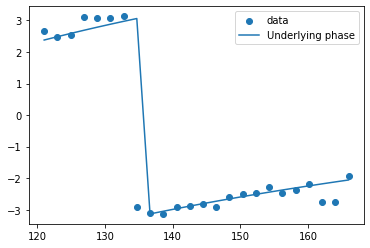

In [3]:
# Generate data
key = random.PRNGKey(43)
key, data_key = random.split(key)
phase_underlying, phase_obs, freqs = generate_data(data_key, 0.25)
plt.scatter(freqs, phase_obs, label='data')
plt.plot(freqs, phase_underlying, label='Underlying phase')
plt.legend()
plt.show()
# Note: the phase wrapping makes this a difficult problem to solve. As we'll see, the posterior is rather complicated.

In [4]:

def log_normal(x, mean, scale):
    dx = (x - mean) / scale
    return -0.5 * jnp.log(2. * jnp.pi) - jnp.log(scale) - 0.5 * dx * dx


def log_likelihood(tec, const, clock, uncert):
    phase = tec * (TEC_CONV / freqs) + const + clock * (CLOCK_CONV * freqs)
    logL = log_normal(wrap(wrap(phase) - wrap(phase_obs)), 0., uncert)
    return jnp.sum(logL)


with PriorChain() as prior_chain:
    CauchyPrior('tec', 0., 100.)
    UniformPrior('const', -jnp.pi, jnp.pi)
    UniformPrior('clock', -2., 2.)
    HalfLaplacePrior('uncert', 0.5)

In [5]:
# The analytic evidence, from brute-force calculation (warning uses > 2GB RAM)
log_Z = analytic_log_evidence(prior_chain, log_likelihood, S=60)

print(f"True log(Z): {log_Z}")

True log(Z): -4.740497589111328


In [6]:
# We'll use dynamic nested sampling
ns = NestedSampler(log_likelihood, prior_chain, num_parallel_samplers=1)

# We'll be interested in also refining the solution later, so we'll also return the state.
# Since return_state invokes a python switch, we need to make it a static argument when jit-compiling.
# For a dynamic goal, we'll to minimise evidence uncertainty, G -> 0.
# For a dynamic termination condition, we'll start with log_Z uncertainty < 0.1

ns = jit(ns)
results = ns(key, adaptive_evidence_patience=2)
results.ESS.block_until_ready()
t0 = default_timer()
results = ns(key, adaptive_evidence_patience=2)
results.ESS.block_until_ready()
print(f"Computation took: {default_timer() - t0}")


WARNING[2022-05-30 11:02:03,840]: Increasing max_samples (100000) by 400 to evenly divide samples_per_step
WARNING[2022-05-30 11:02:03,841]: PriorChain was already built. You may be trying to re-use a PriorChain in another NestedSampler. Use the same sample NestedSampler.
/home/albert/miniconda3/envs/jaxns_py/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:1882: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "asarray")


Computation took: 3.5851568039506674


In [7]:
#Let's look at what we have so far.
summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 2461349
# samples: 5200
# likelihood evals / sample: 473.3
--------
logZ=-5.02 +- 0.15
H=45.0
ESS=953
--------
clock: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
clock: 0.55 +- 0.94 | -0.8 / 0.72 / 1.75 | 1.24 | -1.1
--------
const: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
const: 0.3 +- 1.7 | -1.7 / 0.1 / 2.8 | -0.1 | -2.8
--------
tec: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
tec: 65.0 +- 15.0 | 46.0 / 64.0 / 86.0 | 64.0 | 91.0
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.217 +- 0.035 | 0.177 / 0.212 / 0.266 | 0.233 | 0.194
--------


'--------\nTermination Conditions:\nSmall remaining evidence\n--------\n# likelihood evals: 2461349\n# samples: 5200\n# likelihood evals / sample: 473.3\n--------\nlogZ=-5.02 +- 0.15\nH=45.0\nESS=953\n--------\nclock: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\nclock: 0.55 +- 0.94 | -0.8 / 0.72 / 1.75 | 1.24 | -1.1\n--------\nconst: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\nconst: 0.3 +- 1.7 | -1.7 / 0.1 / 2.8 | -0.1 | -2.8\n--------\ntec: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\ntec: 65.0 +- 15.0 | 46.0 / 64.0 / 86.0 | 64.0 | 91.0\n--------\nuncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\nuncert: 0.217 +- 0.035 | 0.177 / 0.212 / 0.266 | 0.233 | 0.194\n--------'

WARNING[2022-05-30 11:02:19,701]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
WARNING[2022-05-30 11:02:20,278]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


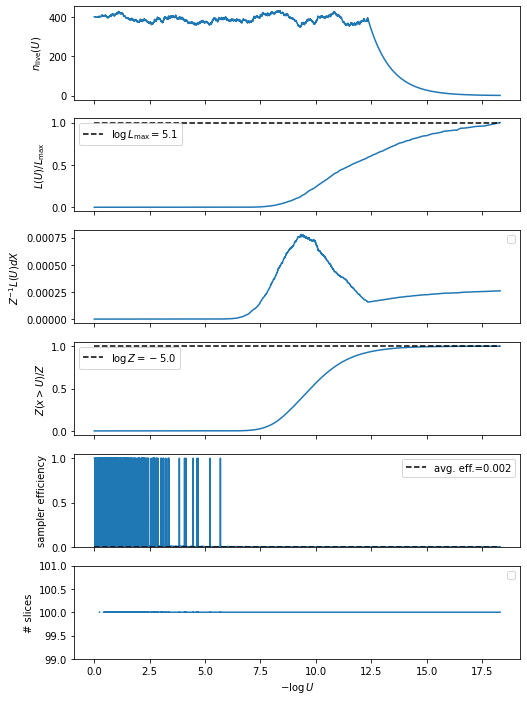

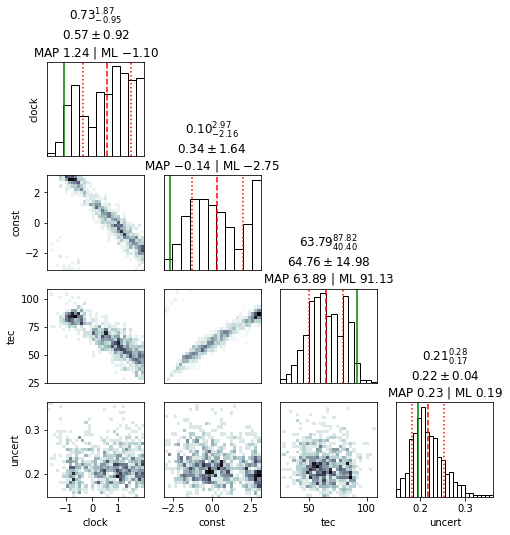

In [8]:
# Finally let's look at the results.
plot_diagnostics(results)
plot_cornerplot(results)

# We can see that the sampler focused more on the initial part of the enclosed prior volume when -logX < 7.5.
# This is evident in the increased n_live points.